In [1]:
import sys
sys.path.append('../')

import numpy as np
import pygme

%load_ext autoreload
%autoreload 2

from pygme import GuidedModeExp, Circle, PhotCryst, Lattice
from pygme.guided_modes_new import guided_modes
import matplotlib.pyplot as plt
from itertools import zip_longest

## W1 waveguide supercell

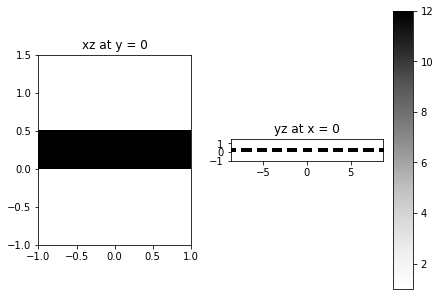

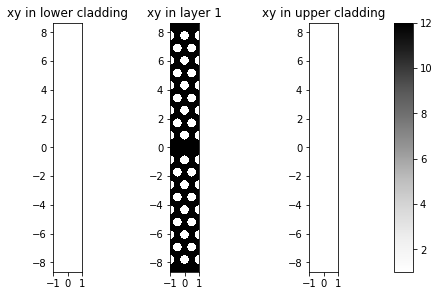

In [15]:
# Number of PhC periods in vertical direction
Ny = 10
# Radius of circle holes
ra = 0.3
# Initialize a lattice
lattice = Lattice([1., 0], [0, Ny*np.sqrt(3)/2])
# Initialize a PhC (by default with eps = 1 in upper and lower cladding, we set upper one to 5)
phc = PhotCryst(lattice)
# Add a layer to the PhC with thickness 1 and background permittivity 10
phc.add_layer(d=0.5, eps_b=12.)
# Add a shape to this layer 
for ih in range(Ny):
    if ih != Ny//2:
        circ = Circle(x_cent=(ih%2)*0.5, y_cent = (-Ny//2 + ih)*np.sqrt(3)/2, r=ra)
        phc.layers[-1].add_shape(circ)
# Plot an overview picture
phc.plot_overview(cladding='True', Ny=500)

## Define and run the guided mode expansion

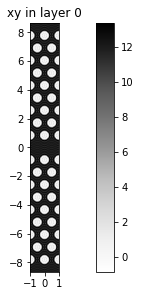

In [16]:
gme = GuidedModeExp(phc, gmax=3)
gme.plot_overview_ft(Ny=500)

In [19]:
print(gme.gvec.shape)
print(np.int_(2.9))

(2, 357)
2


In [20]:
path = phc.lattice.bz_path(['G', np.array([np.pi, 0])], [100])

In [ ]:
gme.run(kpoints=path.kpoints, gmode_inds=[0], N_g_array = 500, verbose=False)

0 0


Exception: 

> /Users/momchilminkov/Drive/Postdoc/Python/pyGME/pygme/gme.py(431)mat_te_te()
    429 
    430                 # mat = mat*np.outer(np.conj(chis1[-1, :]), chis2[-1, :])
--> 431                 raise Exception
    432 
    433                 # Contributions from layers

ipdb> np.amax(np.real(mat))
1.0643784238595626


In [76]:
print(gme.freqs)

[[0.08309732 0.08598572 0.1371786  ... 0.49878437 0.50128397 0.50444015]
 [0.00119853 0.08315951 0.08604759 ... 0.4941348  0.49885841 0.50113113]
 [0.0035163  0.08334598 0.08623314 ... 0.49453742 0.49907781 0.50076479]
 ...
 [0.21886083 0.23331802 0.23919707 ... 0.51821253 0.52205849 0.52530368]
 [0.21930816 0.23298585 0.23853568 ... 0.51822136 0.5224539  0.52561958]
 [0.21948652 0.23285798 0.23778149 ... 0.51832142 0.52236221 0.52579468]]


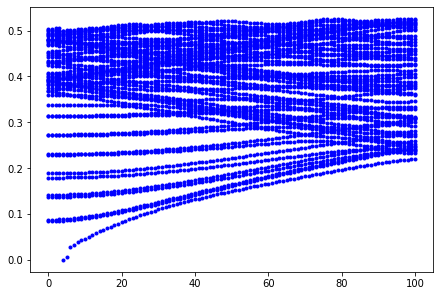

In [6]:
# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(gme.freqs, '.b')
# # plt.plot(freqs_te, 'r')
# ax.set_ylim([0, 0.5])
# ax.set_xlim([0, gme.freqs.shape[0]-1])

In [7]:
print(gme.N_basis, gme.modes_numg)

[356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357] [[356], [356], [356], [356], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [357], [35